# Leave-one-out cross-validation

Leave-one-out cross-validation is a simple generic tool for selecting the best empirical model. When we model data empirically, for example, with a polynomial, we want to select the model which provides the best compromise between bias and variance. If the empirical model is too simple, it won't be able to describe the data properly and the result is biased. If the model is too flexible, it will start to follow statistical noise, this leads to an increased variance. This is called overfitting and leads to poor generalization of the model.

The general steps for LOO cross-validation are:

- Remove i-th datum from input data set
- Fit model to remaining data set
- Use fitted model to predict the i-th datum and store difference to original i-th datum
- Do this for all i and compute variance of the differences
- Select model with the smallest variance

The variance computed in this way is the mean-squared-error, which consists of a bias term squared and the variance. Minimizing this thus finds the best compromise between the two terms.

We first use the jackknife resampling to implement this algorithm manually, then we use the function `cross_validation` which simplifies the process.

I demonstrate below how to select the optimal order for a polynomial model with leave-one-out (LOO) cross validation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares
from resample.jackknife import resample, cross_validation

I create some toy data that follows polynomials of increasing degree.

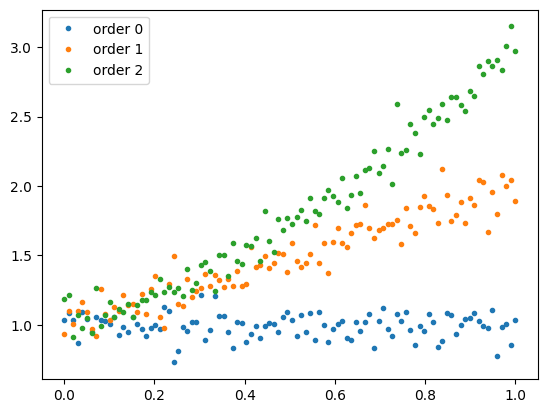

In [2]:
rng = np.random.default_rng(seed=1)

x = np.linspace(0, 1, 100)
y_set = np.empty((3, len(x)))
for poly_order in (0, 1, 2):
    y_set[poly_order] = np.polyval(np.ones(poly_order + 1), x) + rng.normal(0, 0.1, len(x))
    
for poly_order, y in enumerate(y_set):
    plt.plot(x, y, ".", label=f"order {poly_order}")
plt.legend();

In [7]:
# apply leave-one-out cross-validation

def predict(xin, yin, xout, order):
    def model(x, par):
        return np.polyval(par, x)

    # least-squares cost function to fit a polynomial to the toy data
    cost = LeastSquares(xin, yin, 0.1, model)
    m = Minuit(cost, np.zeros(order+1))
    m.strategy = 0 # faster, do not compute errors automatically
    m.migrad()
    assert m.valid

    return model(xout, m.values)


data = []
for poly_order, y in enumerate(y_set):

    variances = []
    poly_orders = np.arange(5)
    for poly_order in poly_orders:
        deltas = []

        for iloo, (xloo, yloo) in enumerate(resample(x, y)):
            yi_loo = predict(xloo, yloo, x[iloo], poly_order)
            deltas.append(y[iloo] - yi_loo)

        variances.append(np.var(deltas))
    data.append((poly_orders, variances))

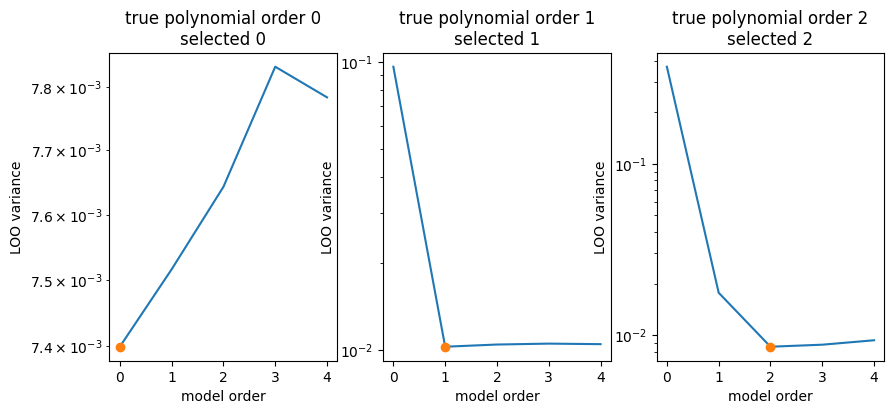

In [8]:
fig, ax = plt.subplots(1, len(data), figsize=(10, 4))
for true_poly_order, (axi, (poly_orders, variances)) in enumerate(zip(ax, data)):
    imin = np.argmin(variances)
    plt.sca(axi)
    plt.title(f"true polynomial order {true_poly_order}\nselected {imin}")
    plt.plot(poly_orders, variances)
    plt.plot(poly_orders[imin], variances[imin], marker="o")
    plt.semilogy()
    plt.ylabel("LOO variance")
    plt.xlabel("model order")

We can slightly simplify this by using `cross_validation` from the library.

In [9]:
data = []
for poly_order, y in enumerate(y_set):
    variances = []
    poly_orders = np.arange(5)
    for poly_order in poly_orders:
        variances.append(cross_validation(predict, x, y, poly_order))
    data.append((poly_orders, variances))

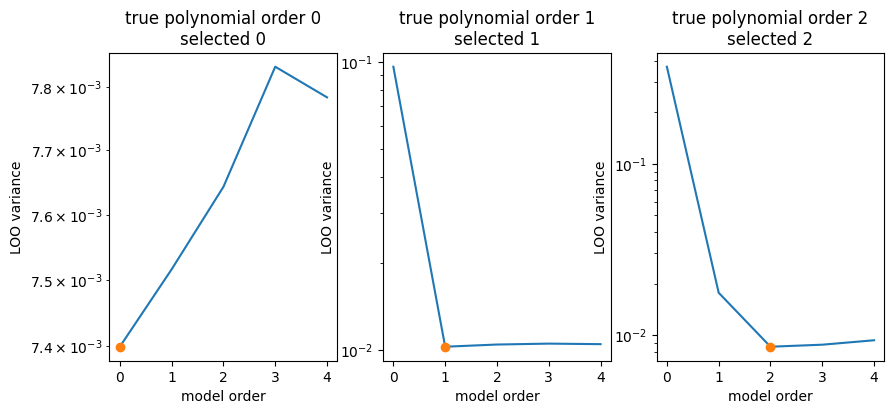

In [10]:
fig, ax = plt.subplots(1, len(data), figsize=(10, 4))
for true_poly_order, (axi, (poly_orders, variances)) in enumerate(zip(ax, data)):
    imin = np.argmin(variances)
    plt.sca(axi)
    plt.title(f"true polynomial order {true_poly_order}\nselected {imin}")
    plt.plot(poly_orders, variances)
    plt.plot(poly_orders[imin], variances[imin], marker="o")
    plt.semilogy()
    plt.ylabel("LOO variance")
    plt.xlabel("model order")